# Final Project (Churn Prediction)
###### Estefania Perez & Daniel Cruz 

### 1. Data Preprocessing

In [1]:
#%pip install imbalanced-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None


First 5 rows:
   RowNumber  CustomerId   Surname  CreditScore Geography  

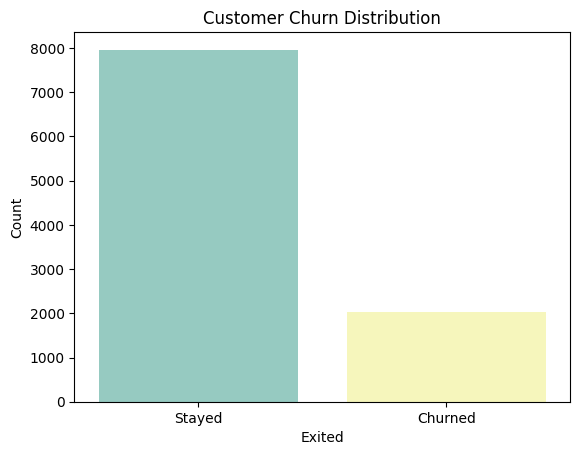

In [2]:
#EDA Summary of Churn_Modeling Dataset
churn_data = pd.read_csv('Churn_Modelling.csv')

print("Dataset Info:")
print(churn_data.info())
print("\n")

print("First 5 rows:")
print(churn_data.head())
print("\n")

print("Dataset Shape:")
print(f"{churn_data.shape[0]} rows, {churn_data.shape[1]} columns\n")

print("\n")
print(f"Chrun Percentage:\n {churn_data['Exited'].value_counts(normalize=True) * 100}")

sns.countplot(x='Exited', hue='Exited', data=churn_data, palette='Set3', legend=False)
plt.title('Customer Churn Distribution')
plt.xlabel('Exited')
plt.ylabel('Count')
plt.xticks([0, 1], ['Stayed', 'Churned'])
plt.show()

In [3]:
'''
Cleaning/Preparing The Chrun Data
- Dropping Irrelevant Columns
- Encoding Categorical Variables
- Splitting into Train/Test Sets (80/20)
'''

#dropping irrelevant columns (RowNumber, CustomerId, Surname)
churn_data = churn_data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

#Encoding Categorical Variables (Gender (Binary Encoding) and Geography(One-hot encoding))
churn_data['Gender'] = churn_data['Gender'].map({'Female': 0, 'Male':1})
#Need to elaborate why we used get_dummies and drop_first
churn_data = pd.get_dummies(churn_data, columns = ['Geography'], drop_first=True)
print("Data is now Encoded Properly:")
print(churn_data.head())


#False, False = Francex
#True, False = Germany
#False, True = Spain

Data is now Encoded Properly:
   CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619       0   42       2       0.00              1          1   
1          608       0   41       1   83807.86              1          0   
2          502       0   42       8  159660.80              3          1   
3          699       0   39       1       0.00              2          0   
4          850       0   43       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  Geography_Germany  Geography_Spain  
0               1        101348.88       1              False            False  
1               1        112542.58       0              False             True  
2               0        113931.57       1              False            False  
3               0         93826.63       0              False            False  
4               1         79084.10       0              False             True  


X_train shape: (8000, 11)
X_test shape: (2000, 11)

y_train distribution:
 Exited
0    0.79625
1    0.20375
Name: proportion, dtype: float64
y_test distribution:
 Exited
0    0.7965
1    0.2035
Name: proportion, dtype: float64


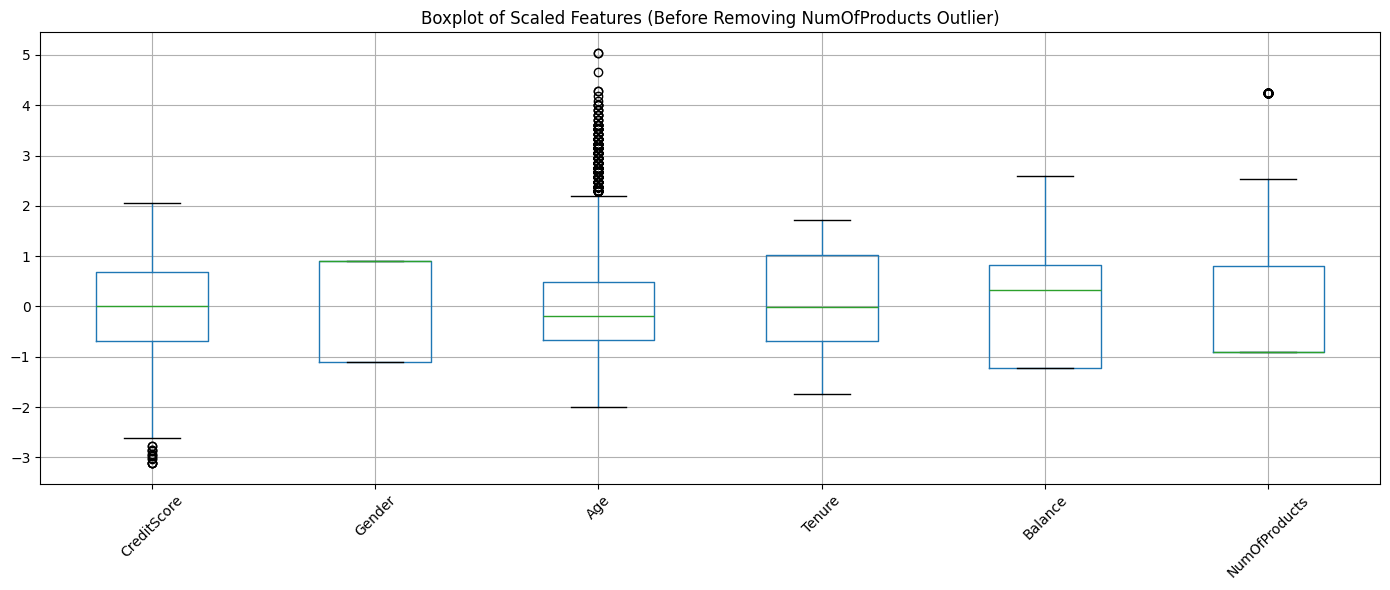


Removed 50 rows with NumOfProducts > 3
X_train shape after removal: (7950, 11)


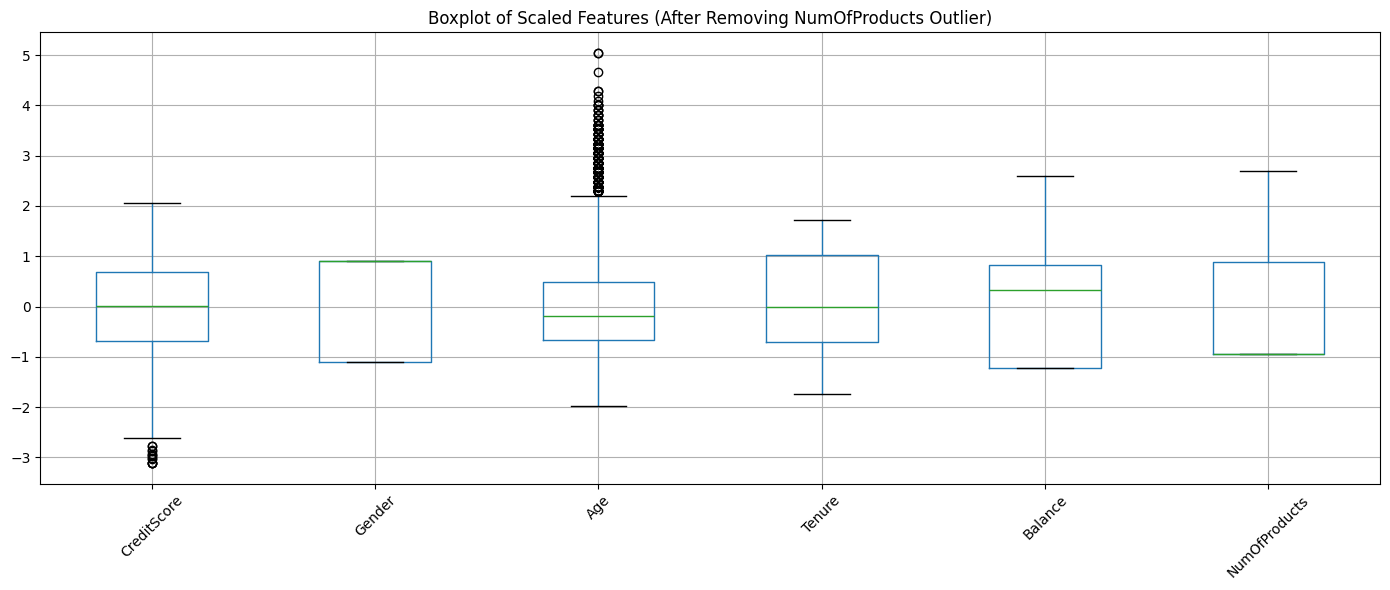


Class distribution after SMOTE:
Exited
1    6370
0    6370
Name: count, dtype: int64


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Split the dataset into features (X) and target variable (y)
X = churn_data.drop('Exited', axis=1)
y = churn_data['Exited']

#Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#Display the shape of training and test sets to verify correct splitting
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("\ny_train distribution:\n", y_train.value_counts(normalize=True))
print("y_test distribution:\n", y_test.value_counts(normalize=True))

#Scale the training features using StandardScaler and convert the result back to a DataFrame for easier interpretation
scaler_before = StandardScaler()
X_train_scaled_before = scaler_before.fit_transform(X_train)
X_train_scaled_df_before = pd.DataFrame(X_train_scaled_before, columns=X_train.columns)

#Boxplot BEFORE removing NumOfProducts > 3
plt.figure(figsize=(14, 6))
X_train_scaled_df_before.iloc[:, :6].boxplot()
plt.title("Boxplot of Scaled Features (Before Removing NumOfProducts Outlier)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Remove only NumOfProducts outlier
initial_rows = X_train.shape[0]
mask = X_train['NumOfProducts'] <= 3
X_train = X_train[mask]
y_train = y_train[mask]
removed_rows = initial_rows - X_train.shape[0]

print(f"\nRemoved {removed_rows} rows with NumOfProducts > 3")
print("X_train shape after removal:", X_train.shape)

#Scale after removal for boxplo, also used for model training
scaler_after = StandardScaler()
X_train_scaled_after = scaler_after.fit_transform(X_train)
X_train_scaled_df_after = pd.DataFrame(X_train_scaled_after, columns=X_train.columns)

#Boxplot AFTER removing NumOfProducts outlier
plt.figure(figsize=(14, 6))
X_train_scaled_df_after.iloc[:, :6].boxplot()
plt.title("Boxplot of Scaled Features (After Removing NumOfProducts Outlier)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#For SMOTE training with the models
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_scaled_after, y_train)

#Note: We use the same X_test_scaled for evaluating both the SMOTE and non-SMOTE models.
#This ensures a fair comparison, as the test set remains untouched and reflects the original class imbalance.
#SMOTE is only applied to the training data to help the model learn from a balanced dataset.
X_test_scaled = scaler_after.transform(X_test)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

### 2. Model Design and Training

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# === TRAIN MODELS WITH class_weight='balanced' ===
print("=== Model Performance ===\n")

#Decision Tree (using previous HW as reference)
print("Decision Tree: (Without SMOTE)")
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))
print("-" * 50)

print("Decision Tree: (With SMOTE)")
dt_smote = DecisionTreeClassifier(random_state=42)
dt_smote.fit(X_resampled, y_resampled)
y_pred_dt_smote = dt_smote.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt_smote):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_dt_smote))
print("-" * 50)

#MLP (again, using previous HW as reference)
print("MLP Classifier (With SMOTE):")
mlp_smote = MLPClassifier(random_state=42, max_iter=900)
mlp_smote.fit(X_resampled, y_resampled)
y_pred_mlp_smote = mlp_smote.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp_smote):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_mlp_smote))
print("-" * 50)

print("MLP Classifier (Without SMOTE):")
mlp_model = MLPClassifier(random_state=42, max_iter=900)
mlp_model.fit(X_train_scaled_after, y_train)
y_pred_mlp = mlp_model.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_mlp))
print("-" * 50)

#Logistic Regression (again, using previous HW as reference)
print("Logistic Regression: (Without SMOTE)")
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled_after, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("-" * 50)

print("Logistic Regression: (With SMOTE)")
lr_smote = LogisticRegression(max_iter=1000, random_state=42)
lr_smote.fit(X_resampled, y_resampled)
y_pred_lr_smote = lr_smote.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_smote):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr_smote))
print("-" * 50)

#Random Forest (again, using previous HW as reference)
print("Random Forest: (With SMOTE)")
rf_model_smote = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42
)
rf_model_smote.fit(X_resampled, y_resampled)
y_pred_rf_smote = rf_model_smote.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_smote):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf_smote))
print("=" * 60)

print("Random Forest: (Without SMOTE)")
rf_model = RandomForestClassifier(
    class_weight = 'balanced',
    n_estimators=100,
    max_depth=None,
    random_state=42
)
rf_model.fit(X_train_scaled_after, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("=" * 60)

=== Model Performance ===

Decision Tree: (Without SMOTE)
Accuracy: 0.7735
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1593
           1       0.44      0.43      0.43       407

    accuracy                           0.77      2000
   macro avg       0.65      0.64      0.65      2000
weighted avg       0.77      0.77      0.77      2000

--------------------------------------------------
Decision Tree: (With SMOTE)
Accuracy: 0.7620
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1593
           1       0.43      0.55      0.48       407

    accuracy                           0.76      2000
   macro avg       0.65      0.68      0.66      2000
weighted avg       0.79      0.76      0.77      2000

--------------------------------------------------
MLP Classifier (With SMOTE):
Accuracy: 0.8055
Classification Report:
         

In [6]:
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

print("=== Three Ensemble Methods ===\n")

#Balanced Random Forest (undersampling without replacement)
print("Balanced Random Forest:")
brf = BalancedRandomForestClassifier(
    n_estimators=100,
    replacement=False, #ensures no duplicate samples in each bootstrap
    random_state=42
)
brf.fit(X_train_scaled_after, y_train)  #uses scaled, imbalanced train set
y_pred_brf = brf.predict(X_test_scaled) #predicts on untouched, scaled test set
print(f"Accuracy: {accuracy_score(y_test, y_pred_brf):.4f}")
print(classification_report(y_test, y_pred_brf))
print("-" * 50)

#XGBoost (trained on SMOTE data) (using previous HW as reference)
print("XGBoost (with SMOTE):")
xgb = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_resampled, y_resampled) #X_resampled, y_resampled from SMOTE
y_pred_xgb = xgb.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(classification_report(y_test, y_pred_xgb))
print("-" * 50)

#Stacking Classifier (BRF + XGB + balanced LR → LR meta‑learner)
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html
print("Stacking Classifier (BRF + XGB + LR):")
stack_estimators = [
    ('brf', BalancedRandomForestClassifier(n_estimators=100, replacement=False, random_state=42)),
    ('xgb', xgb),  # reuse the same XGB instance
    ('lr',  LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
]
stack = StackingClassifier( #initializing the StackingClassifier
    estimators=stack_estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5,
    stack_method='predict_proba'
)
stack.fit(X_resampled, y_resampled)
y_pred_stack = stack.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_stack):.4f}")
print(classification_report(y_test, y_pred_stack))
print("=" * 60)

=== Three Ensemble Methods ===

Balanced Random Forest:
Accuracy: 0.7785
              precision    recall  f1-score   support

           0       0.93      0.78      0.85      1593
           1       0.47      0.78      0.59       407

    accuracy                           0.78      2000
   macro avg       0.70      0.78      0.72      2000
weighted avg       0.84      0.78      0.80      2000

--------------------------------------------------
XGBoost (with SMOTE):
Accuracy: 0.8420
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1593
           1       0.63      0.53      0.58       407

    accuracy                           0.84      2000
   macro avg       0.76      0.73      0.74      2000
weighted avg       0.83      0.84      0.84      2000

--------------------------------------------------
Stacking Classifier (BRF + XGB + LR):
Accuracy: 0.8450
              precision    recall  f1-score   support

           0       0.8

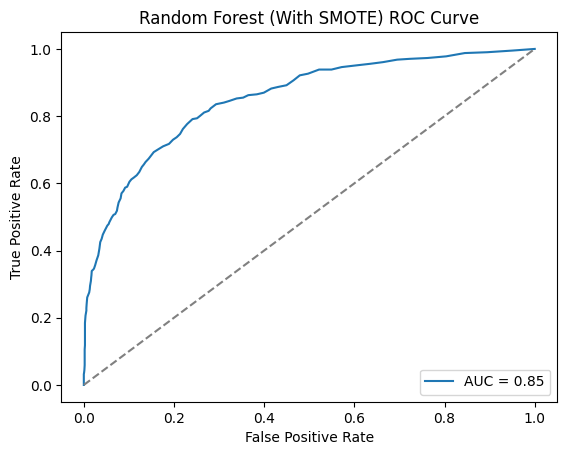

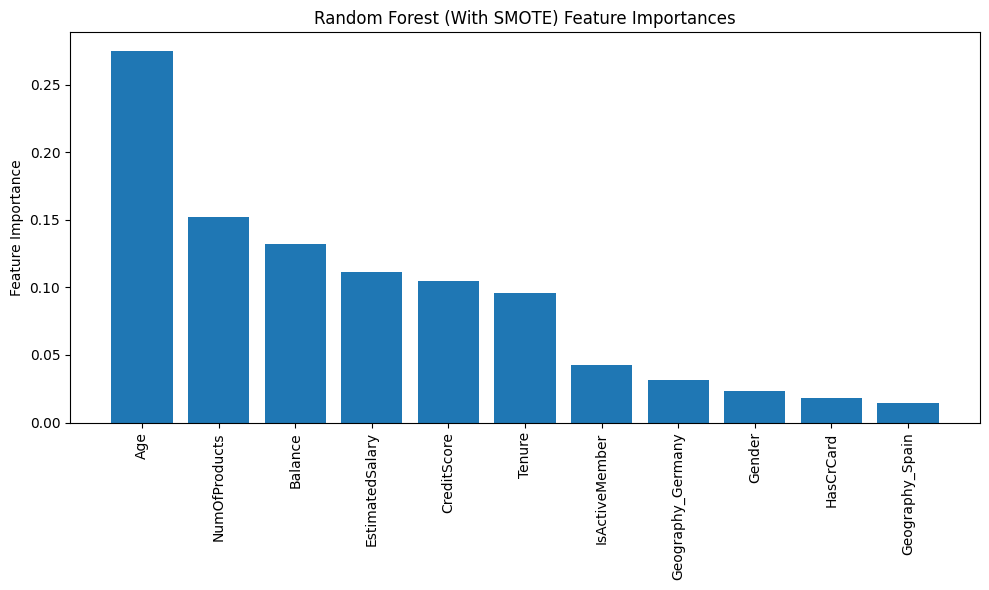

In [7]:
#Our best one is random forest
from sklearn.metrics import roc_curve, auc

#ROC Curve and AUC (using previous HW as reference)
y_score_smote = rf_model_smote.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score_smote)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest (With SMOTE) ROC Curve")
plt.legend(loc="lower right")
plt.show()

#Feature Importance
importances = rf_model_smote.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns #original feature names

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.ylabel("Feature Importance")
plt.title("Random Forest (With SMOTE) Feature Importances")
plt.tight_layout()
plt.show()

### 3. Model Improvements

#### Hyperparamter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

#Hyperparameter tuning for Random Forest with SMOTE (using HW also as reference)
#Sources that also helped: https://medium.com/cloudvillains/random-forest-with-grid-search-b739fb0da311
#https://www.kdnuggets.com/2022/10/hyperparameter-tuning-grid-search-random-search-python.html

rf_model_smote = RandomForestClassifier( #the rf_model_smote we used before
    n_estimators=100,
    max_depth=None,
    random_state=42
)

#parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 10], #max level of a tree
    'n_estimators': [50, 100, 150, 200], #number of trees in the forest
    'min_samples_split': [2, 4], #minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2] #minimum number of samples required to be at a leaf node
}

#GridSearchCV
grid_search = GridSearchCV(rf_model_smote, param_grid, cv=5, scoring='f1', n_jobs=-1) 
grid_search.fit(X_resampled, y_resampled)

print("Best Hyperparameters: " + str(grid_search.best_params_)) 

y_pred_best = grid_search.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_best))


Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.8165
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      1593
           1       0.54      0.71      0.61       407

    accuracy                           0.82      2000
   macro avg       0.73      0.78      0.75      2000
weighted avg       0.84      0.82      0.83      2000



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

#https://www.kdnuggets.com/2022/10/hyperparameter-tuning-grid-search-random-search-python.html
#https://jamesrledoux.com/code/randomized_parameter_search

rf_model_smote = RandomForestClassifier( #the rf_model_smote we used before
    n_estimators=100,
    max_depth=None,
    random_state=42
)

#parameter grid for RandomizedSearchCV
rand_grid = {
    'n_estimators': randint(50, 301), #number of trees in the forest
    'max_depth': [None] + list(range(3, 21)), #max level of a tree
    'min_samples_split': randint(2, 11), #minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 11) #minimum number of samples required to be at a leaf node
}

#RandomizedSearchCV
rand_search = RandomizedSearchCV(rf_model_smote, param_distributions=rand_grid, n_iter=60, cv=5, scoring='f1', n_jobs=-1, random_state=42)
rand_search.fit(X_resampled, y_resampled)

print("Best Hyperparameters: " + str(rand_search.best_params_))

y_pred_best_rand = rand_search.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_rand):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_best_rand))

Best Hyperparameters: {'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 269}
Accuracy: 0.8360
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1593
           1       0.59      0.65      0.62       407

    accuracy                           0.84      2000
   macro avg       0.75      0.77      0.76      2000
weighted avg       0.84      0.84      0.84      2000



### Model Fusion

In [10]:
from sklearn.ensemble import VotingClassifier

#https://www.geeksforgeeks.org/voting-classifier/

#Re-initialize models (with the same parameters you used before)
rf_model_smote = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42
)
xgb_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

#Train both models on resampled training data
rf_model_smote.fit(X_resampled, y_resampled)
xgb_model.fit(X_resampled, y_resampled)

#Create soft voting ensemble
voting_model = VotingClassifier(
    estimators=[
        ('rf', rf_model_smote),
        ('xgb', xgb_model)
    ],
    voting='soft'  #soft voting uses predicted probabilities
)

#Fit voting model on the same resampled training data
voting_model.fit(X_resampled, y_resampled)

#Predict on test set
y_pred_voting = voting_model.predict(X_test_scaled)

#Evaluate performance
print("Soft Voting Classifier (Random Forest + XGBoost):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_voting):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_voting))



Soft Voting Classifier (Random Forest + XGBoost):
Accuracy: 0.8450
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1593
           1       0.64      0.56      0.60       407

    accuracy                           0.84      2000
   macro avg       0.76      0.74      0.75      2000
weighted avg       0.84      0.84      0.84      2000



### Feature Selection (RFE)

In [11]:
from sklearn.feature_selection import RFE

#https://stackoverflow.com/questions/74214863/recursive-feature-elimination-rfe-with-random-forest
#https://medium.com/@loyfordmwenda/recursive-feature-rfe-elimination-with-scikit-learn-d0d29e96273d

rf_model_smote = RandomForestClassifier( #the rf_model_smote we used before
    n_estimators=100,
    max_depth=None,
    random_state=42
)

rfe = RFE(estimator=rf_model_smote, n_features_to_select=11, step=1) #initializing RFE with the Random Forest model
X_resampled_rfe = rfe.fit_transform(X_resampled, y_resampled) #training RFE on the resampled data
X_test_rfe = rfe.transform(X_test_scaled) #transforming the test data using the fitted RFE model
rf_model_smote.fit(X_resampled, y_resampled) #fitting the Random Forest model on the resampled data with RFE features
y_pred = rf_model_smote.predict(X_test_rfe) #predicting on the test data with RFE features

print("Random Forest with RFE Feature Selection:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Random Forest with RFE Feature Selection:
Accuracy: 0.839
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1593
           1       0.60      0.60      0.60       407

    accuracy                           0.84      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.84      0.84      0.84      2000

